In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Path to dataset files:", path)

100%|██████████| 329M/329M [00:02<00:00, 122MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1


In [11]:
dataset_dir = os.path.join(path, 'PlantVillage')
dir = os.listdir(dataset_dir)
for filenames in dir:
    print(filenames)

Potato___Late_blight
Tomato_Leaf_Mold
Pepper__bell___Bacterial_spot
Tomato_Bacterial_spot
Potato___healthy
Tomato__Tomato_YellowLeaf__Curl_Virus
Potato___Early_blight
Tomato_Early_blight
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Late_blight
Tomato__Tomato_mosaic_virus
Tomato_healthy
Tomato_Septoria_leaf_spot
Pepper__bell___healthy
Tomato__Target_Spot


In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 40

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


#Dataset Exploration

In [13]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [14]:
len(dataset)

645

In [15]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape, label_batch.numpy())

(32, 256, 256, 3)
(32,) [ 0 11  9  7 13  7  9  5  6  5  6  7  9  7  2 14 14  2  7 13 10 13  5  7
  9 11  5  2 10  7 11  7]


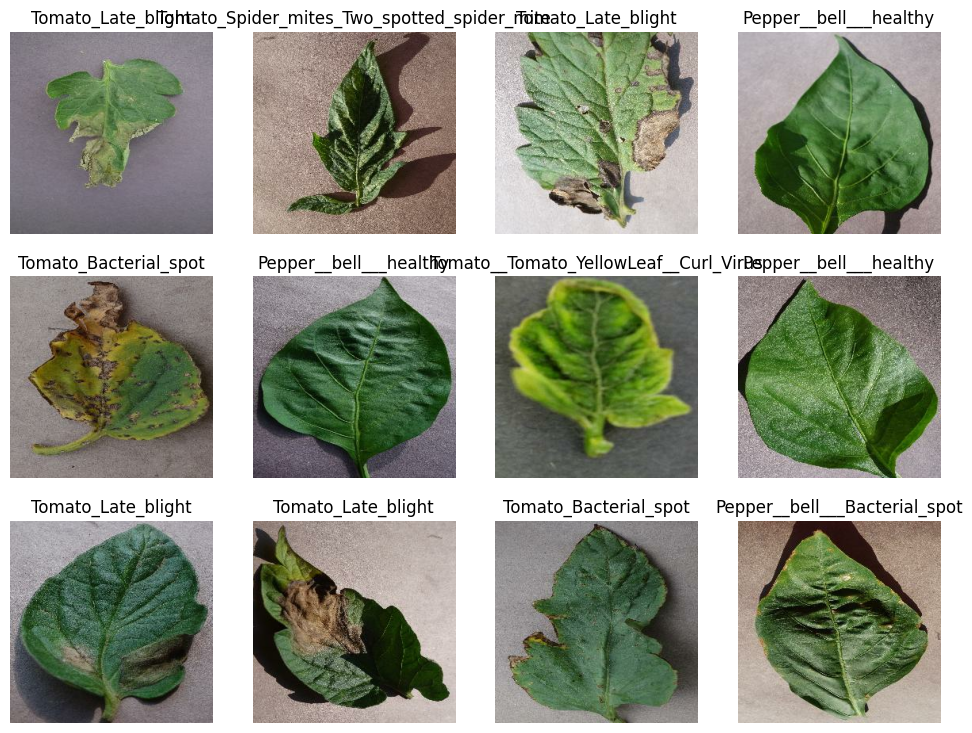

In [16]:
# everytime will see diff image, shuffle is enable
plt.figure(figsize=(12, 9))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        # print(img_batch[i].shape, label_batch[i].numpy())
        plt.imshow(img_batch[i].numpy().astype(int))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis('off')

In [17]:
def get_dataset_partitions_tf(ds, tran_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=24)

    train_size = int(tran_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

#Dataset split

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])